In [105]:
correction_type = ['relative', 'absolute'][1]

In [106]:
from PIL import Image
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt

In [107]:
plt.rc('figure', figsize=(10, 6))

In [108]:
if correction_type == 'absolute':
    # absolute correction
    dfa = pd.read_excel(r'wuce_points.xlsx', usecols='A:E')
    dfa = dfa.rename({'X': 'Y', 'Y': 'X'}, axis='columns')

else:
    # relative corretion
    dfa = pd.read_excel(r'wuce_points.xlsx', usecols='A,D:G')
    dfa = dfa.rename({'relativex': 'X', 'relativey': 'Y'}, axis='columns')

df = dfa[dfa['name'] != 'KC8'].copy()
df

,name,Y,X,x,y
0,KC1,378726.36,534063.76,401,609
1,KC2,379116.64,534031.25,441,143
2,KC3,379153.40,534210.20,662,135
3,KC4,378837.81,533738.74,41,407
4,KC5,379107.40,533716.00,71,87
5,KC6,378941.40,534196.40,600,382
6,KC7,379092.40,533853.10,227,134


# Centeralization

In [109]:
df['cX'] = df['X'] - df['X'].mean()
df['cY'] = df['Y'] - df['Y'].mean()
df['cx'] = df['x'] - df['x'].mean()
df['cy'] = df['y'] - df['y'].mean()
df

,name,Y,X,x,y,cX,cY,cx,cy
0,KC1,378726.36,534063.76,401,609,90.981429,-270.127143,52.0,338.0
1,KC2,379116.64,534031.25,441,143,58.471429,120.152857,92.0,-128.0
2,KC3,379153.40,534210.20,662,135,237.421429,156.912857,313.0,-136.0
3,KC4,378837.81,533738.74,41,407,-234.038571,-158.677143,-308.0,136.0
4,KC5,379107.40,533716.00,71,87,-256.778571,110.912857,-278.0,-184.0
5,KC6,378941.40,534196.40,600,382,223.621429,-55.087143,251.0,111.0
6,KC7,379092.40,533853.10,227,134,-119.678571,95.912857,-122.0,-137.0


In [110]:
def Bfunc(X, Y):
    return np.stack([np.ones_like(X), X, Y, X*X, X*Y, Y*Y], axis=1)

In [111]:
def polynomial_fit(px1, py1, xory):
    """2 degrees polynomial fit from p1 to p2"""
    x = xory
    
    params = np.zeros(6)
    B = Bfunc(px1, py1)
    L = x- B @ params
    param_correction = inv(B.T @ B) @ B.T @ L
    params += param_correction
    V = B @ param_correction - L
    sigma0 = V.T @ V
    return params, sigma0

In [112]:
def cols(*allcols):
    return list(map(lambda c: df[c].values, allcols))

In [113]:
params_a, sigma0a = polynomial_fit(*cols('cX', 'cY', 'cx'))
params_b, sigma0b = polynomial_fit(*cols('cX', 'cY', 'cy'))
params_c, sigma0c = polynomial_fit(*cols('cx', 'cy', 'cX'))
params_d, sigma0d = polynomial_fit(*cols('cx', 'cy', 'cY'))
sigma0a, sigma0b, sigma0c, sigma0d

(0.08012093892315544,
 0.05297953486199611,
 0.032839892144580975,
 0.04661908835598373)

In [114]:
df_param = pd.DataFrame(np.vstack([params_a, params_b, params_c, params_d]), columns=[f'a{i}' for i in range(6)], 
                        index=['Direct_x', 'Direct_y', 'Inverse_X', 'Inverse_Y'])
df_param['sigma0'] = [sigma0a, sigma0b, sigma0c, sigma0d]
df_param.to_excel(f'output/correction/parameters_{correction_type}.xlsx')

In [115]:
x, y, X, Y = cols('x', 'y', 'X', 'Y')

X0 = df['X'].mean()
Y0 = df['Y'].mean()
x0 = df['x'].mean()
y0 = df['y'].mean()

def XYtoxy(X, Y):
    B = Bfunc(X - X0, Y - Y0)
    xc = B @ params_a
    yc = B @ params_b
    return xc + x0, yc + y0

def  xytoXY(x, y):
    B = Bfunc(x - x0, y - y0)
    Xc = B @ params_c
    Yc = B @ params_d
    return Xc + X0, Yc + Y0

# Resampling

In [116]:
img = np.array(Image.open('data/correction/wucesource.tif'))
img.shape

(675, 696, 3)

In [117]:
h, w = img.shape[:2]
x4 = np.array([0, 0, w, w])
y4 = np.array([0, h, 0, h])

X4, Y4 = xytoXY(x4, y4)

X1, X2 = X4.min(), X4.max()
Y1, Y2 = Y4.min(), Y4.max()

X2 - X1, Y2 - Y1

(670.07216421864, 659.4758267187863)

In [118]:
Xs = np.arange(X1, X2+.1, 1)
Ys = np.arange(Y1, Y2+.1, 1)

Xs, Ys = np.meshgrid(Xs, Ys)
new_img_shape = Xs.shape
Xs, Ys = Xs.flatten(), Ys.flatten()

xs, ys = XYtoxy(Xs, Ys)
j, i = xs, ys

In [119]:
i.shape

(442860,)

In [120]:
def bilinear(i, j, img):
    iint = np.int32(i)
    p = i - iint
    jint = np.int32(j)
    q = j - jint
    
    h, w = img.shape[:2]
    img = np.vstack([img, np.zeros(img.shape[1])])
    img = np.hstack([img, np.zeros((img.shape[0], 1))])
    
    idxi = iint % (h - 1)
    idxj = jint % (w - 1)
    
    i11 = img[idxi,   idxj]
    i12 = img[idxi,   idxj+1]
    i21 = img[idxi+1, idxj]
    i22 = img[idxi+1, idxj+1]
    
    wx1 = 1 - q
    wy1 = 1 - p
    wx2 = q
    wy2 = p
    
    new_img = wx1*wy1*i11 + wx1*wy2*i12 + wx2*wy1*i21 + wx2*wy2*i22
    
    cond = np.logical_or(np.logical_or(iint < 1, iint > h-2), np.logical_or(jint < 1, jint > w - 2))
    new_img[cond] = 0
    
    return new_img

In [121]:
imgr = img[..., 0]
imgg = img[..., 1]
imgb = img[..., 2]
r = bilinear(i, j, imgr).reshape(new_img_shape)
g = bilinear(i, j, imgg).reshape(new_img_shape)
b = bilinear(i, j, imgb).reshape(new_img_shape)

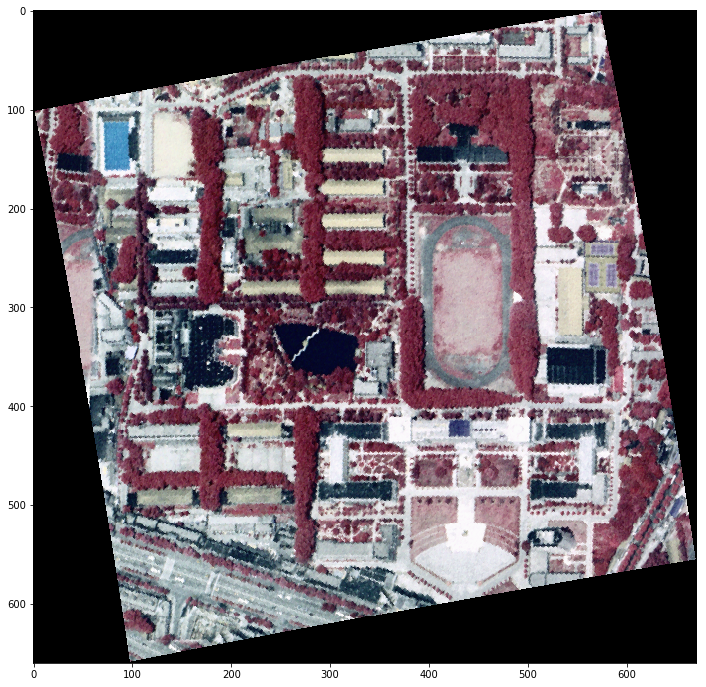

In [122]:
plt.figure(figsize=(20, 12))
imgo = np.stack([r, g, b], axis=2).astype('uint8')

if correction_type == 'absolute':
    imgo = imgo[::-1, :, :]
    plt.imsave('output/correction/wuce_absolute_trans.jpg', imgo)
else: 
    plt.imsave('output/correction/wuce_relative.jpg', imgo)
    
plt.imshow(imgo)

# Evaluation

In [123]:
def cols(*allcols):
    return list(map(lambda c: dfa[c].values, allcols))
x, y, X, Y = cols('x', 'y', 'X', 'Y')

In [124]:
dfa['compx'], dfa['compy'] = XYtoxy(X, Y)
dfa['compX'], dfa['compY'] = xytoXY(x, y)

dfa['dX'] = dfa['X'] - dfa['compX']
dfa['dY'] = dfa['Y'] - dfa['compY']

dfa['dx'] = dfa['x'] - dfa['compx']
dfa['dy'] = dfa['y'] - dfa['compy']

dfa

,name,Y,X,x,y,compx,compy,compX,compY,dX,dY,dx,dy
0,KC1,378726.36,534063.76,401,609,400.993237,609.005499,534063.764218,378726.365025,-0.004218,-0.005025,0.006763,-0.005499
1,KC2,379116.64,534031.25,441,143,441.177041,142.856036,534031.137422,379116.505867,0.112578,0.134133,-0.177041,0.143964
2,KC3,379153.40,534210.20,662,135,661.941777,135.047345,534210.236151,379153.443073,-0.036151,-0.043073,0.058223,-0.047345
3,KC4,378837.81,533738.74,41,407,41.013635,406.988913,533738.731088,378837.799382,0.008912,0.010618,-0.013635,0.011087
4,KC5,379107.40,533716.00,71,87,71.069738,86.943291,533715.954765,379107.346105,0.045235,0.053895,-0.069738,0.056709
5,KC6,378941.40,534196.40,600,382,600.005233,381.995744,534196.397099,378941.396544,0.002901,0.003456,-0.005233,0.004256
6,KC7,379092.40,533853.10,227,134,226.799339,134.163172,533853.229257,379092.554005,-0.129257,-0.154005,0.200661,-0.163172
7,KC8,378777.60,534071.00,418,550,418.940884,549.948361,534070.228712,378777.418834,0.771288,0.181166,-0.940884,0.051639
